<a href="https://colab.research.google.com/github/junduk123/Machine-Learning-Task/blob/main/Task12/CNN_Cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified
Experiment 1/90: Kernel=3, Pooling=max, Optimizer=sgd, Epochs=5
Epoch 1/5 - Loss: 171.4203, Accuracy: 25.53%
Epoch 2/5 - Loss: 145.5991, Accuracy: 36.49%
Epoch 3/5 - Loss: 131.9438, Accuracy: 42.02%
Epoch 4/5 - Loss: 118.9481, Accuracy: 44.72%
Epoch 5/5 - Loss: 109.1490, Accuracy: 48.59%
Experiment 2/90: Kernel=3, Pooling=max, Optimizer=sgd, Epochs=50
Epoch 1/50 - Loss: 171.4403, Accuracy: 25.06%
Epoch 2/50 - Loss: 147.4640, Accuracy: 36.94%
Epoch 3/50 - Loss: 129.9326, Accuracy: 42.22%
Epoch 4/50 - Loss: 115.7802, Accuracy: 46.75%
Epoch 5/50 - Loss: 106.5108, Accuracy: 48.74%
Epoch 6/50 - Loss: 97.7209, Accuracy: 48.99%
Epoch 7/50 - Loss: 90.2472, Accuracy: 50.30%
Epoch 8/50 - Loss: 81.4244, Accuracy: 53.75%
Epoch 9/50 - Loss: 75.2061, Accuracy: 51.97%
Epoch 10/50 - Loss: 65.2557, Accuracy: 54.79%
Epoch 11/50 - Loss: 56.1631, Accuracy: 54.03%
Epoch 12/50 - Loss: 45.9629, Accuracy: 51.93%
Epoch 13/50 - Loss: 37

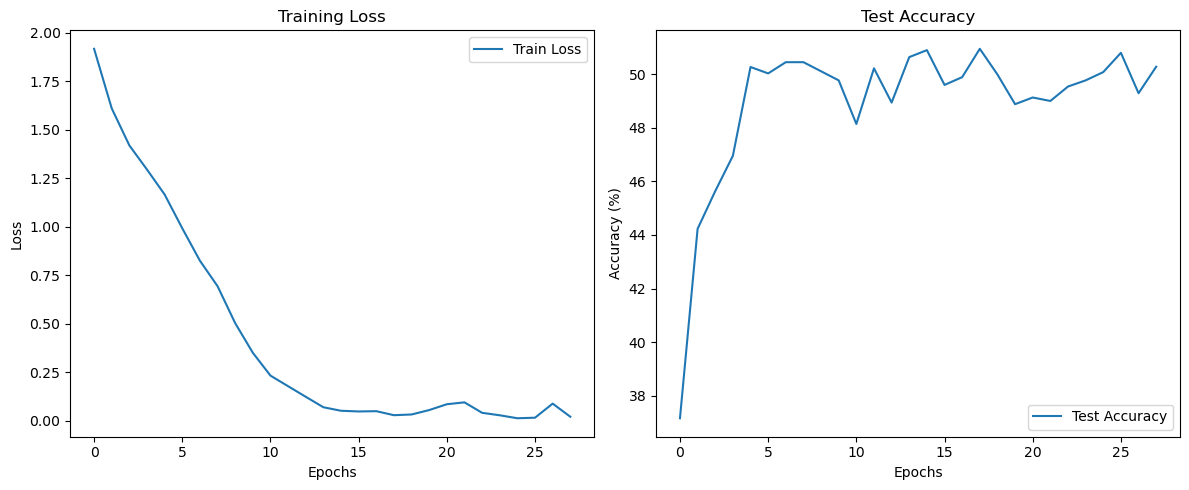

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import random

# Definisi model CNN
class CNN(nn.Module):
    def __init__(self, kernel_size, pooling_type):
        super(CNN, self).__init__()
        self.pooling = nn.MaxPool2d(2, 2) if pooling_type == "max" else nn.AvgPool2d(2, 2)

        self.conv1 = nn.Conv2d(3, 32, kernel_size, padding=kernel_size // 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size, padding=kernel_size // 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pooling(torch.relu(self.conv1(x)))
        x = self.pooling(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Menyiapkan dataset CIFAR-10 dengan subset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Membatasi jumlah data yang digunakan untuk pelatihan
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_subset = Subset(train_dataset, random.sample(range(len(train_dataset)), 5000))

# Dataset pengujian tetap utuh
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Fungsi untuk melatih dan mengevaluasi model
def train_and_evaluate(kernel_size, pooling_type, optimizer_type, epochs, early_stop_patience=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CNN(kernel_size, pooling_type).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = {
        "sgd": optim.SGD(model.parameters(), lr=0.01, momentum=0.9),
        "rmsprop": optim.RMSprop(model.parameters(), lr=0.01),
        "adam": optim.Adam(model.parameters(), lr=0.001)
    }[optimizer_type]

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, verbose=True)

    train_losses = []
    test_accuracies = []
    best_accuracy = 0
    early_stop_counter = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        accuracy = 100 * correct / total
        test_accuracies.append(accuracy)

        scheduler.step(running_loss)

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {running_loss:.4f}, Accuracy: {accuracy:.2f}%")

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= early_stop_patience:
            print("Early stopping triggered.")
            break

    return model, train_losses, test_accuracies

# Visualisasi hasil dataset pengujian
def visualize_test_results(model, test_loader, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    dataiter = iter(test_loader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu().numpy()

    fig, axes = plt.subplots(1, 10, figsize=(20, 4))
    for idx, ax in enumerate(axes):
        img = np.transpose(images[idx], (1, 2, 0))
        img = (img * 0.5) + 0.5
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {classes[labels[idx].item()]},\nPred: {classes[predicted[idx].item()]}")

    plt.tight_layout()
    plt.show()

# Daftar kelas CIFAR-10
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Menjalankan eksperimen
kernel_sizes = [3, 5, 7]
pooling_types = ["max", "avg"]
epochs_list = [5, 50, 100, 250, 350]
optimizers = ["sgd", "rmsprop", "adam"]

results = {}

total_experiments = len(kernel_sizes) * len(pooling_types) * len(epochs_list) * len(optimizers)
current_experiment = 0

for kernel_size in kernel_sizes:
    for pooling_type in pooling_types:
        for optimizer_type in optimizers:
            for epochs in epochs_list:
                current_experiment += 1
                print(f"Experiment {current_experiment}/{total_experiments}: Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer_type}, Epochs={epochs}")
                model, train_losses, test_accuracies = train_and_evaluate(kernel_size, pooling_type, optimizer_type, epochs)

                key = (kernel_size, pooling_type, optimizer_type, epochs)
                results[key] = {
                    "train_losses": train_losses,
                    "test_accuracies": test_accuracies
                }

# Visualisasi hasil
for key, value in results.items():
    kernel_size, pooling_type, optimizer_type, epochs = key
    print(f"Kernel={kernel_size}, Pooling={pooling_type}, Optimizer={optimizer_type}, Epochs={epochs}")
    print(f"Best Accuracy: {max(value['test_accuracies']):.2f}%")
    print("-" * 50)

# Menyimpan hasil eksperimen
np.save("cnn_experiment_results.npy", results)

# Plot hasil eksperimen terakhir
def plot_results(train_losses, test_accuracies):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(test_accuracies, label="Test Accuracy")
    plt.title("Test Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.tight_layout()
    plt.show()

last_key = list(results.keys())[-1]
plot_results(results[last_key]['train_losses'], results[last_key]['test_accuracies'])
